In [462]:
import pandas as pd
from joblib import Parallel, delayed
import re
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
cores = ["#FF007F"]

# Aplicando a paleta personalizada no seaborn
sns.set_palette(cores)

try:
    vendas = pd.read_csv('C:\\Users\\otavi\\Downloads\\kvendas.csv', encoding='latin1', delimiter=';', quoting=0, lineterminator='\n')
    info = vendas.info()
    head = vendas.head()
    error_message = None
except Exception as e:
    error_message = str(e)
    vendas, info, head = None, None, None

vendas, info, head, error_message

display(vendas)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5007 entries, 0 to 5006
Data columns (total 43 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Número do Pedido                                 5007 non-null   int64  
 1   E-mail                                           5007 non-null   object 
 2   Data                                             2911 non-null   object 
 3   Status do Pedido                                 2911 non-null   object 
 4   Status do Pagamento                              2911 non-null   object 
 5   Status do Envio                                  2911 non-null   object 
 6   Moeda                                            2911 non-null   object 
 7   Subtotal                                         2911 non-null   float64
 8   Desconto                                         2911 non-null   float64
 9   Valor do Frete                

,Número do Pedido,E-mail,Data,Status do Pedido,Status do Pagamento,Status do Envio,Moeda,Subtotal,Desconto,Valor do Frete,...,Quantidade Comprada,SKU,Canal,Código de rastreio do envio,Identificador da transação no meio de pagamento,Identificador do pedido,Produto Fisico,Pessoa que registrou a venda,Local de venda,Vendedor
0,3669,fabioladealmeida.s@outlook.com,23/12/2024,Aberto,Confirmado,Enviado,BRL,149.9,0.0,0.0,...,1,NaN,Mobile,"=""""",3716137702,1.612670e+09,Sim,NaN,NaN,NaN
1,3667,paula_abreusp@hotmail.com,23/12/2024,Aberto,Confirmado,Enviado,BRL,109.9,0.0,0.0,...,1,NaN,Mobile,"=""""",ch_peMxmr6sv3SomaG3,1.619955e+09,Sim,NaN,NaN,NaN
2,3666,sabrinnaaires@gmail.com,23/12/2024,Aberto,Confirmado,Pronto para enviar,BRL,149.9,0.0,0.0,...,1,NaN,Mobile,"=""""",ch_WRy4OdYcV3hgpoAM,1.619915e+09,Sim,NaN,NaN,NaN
3,3665,karolnasciimento@hotmail.com,23/12/2024,Aberto,Confirmado,Pronto para enviar,BRL,149.9,0.0,10.0,...,1,NaN,Mobile,"=""""",3713585229,1.619771e+09,Sim,NaN,NaN,NaN
4,3664,isabellasiqgoncalvez@gmail.com,22/12/2024,Aberto,Confirmado,Pronto para enviar,BRL,299.8,0.0,15.0,...,1,NaN,Mobile,"=""""",ch_bAPNL3DC2CwDEZ6M,1.588953e+09,Sim,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5002,399,karen.coutinho@hotmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,Sim,NaN,NaN,NaN
5003,398,karen.coutinho@hotmail.com,02/11/2022,Aberto,Confirmado,Enviado,BRL,35.0,0.0,0.0,...,1,NaN,Mobile,"=""""",DE1EEA42-E591-4686-8031-D4CEB8EE1D86,8.372440e+08,Sim,NaN,NaN,NaN
5004,397,daiane.martinssil92@gmail.com,02/11/2022,Aberto,Confirmado,Enviado,BRL,25.0,0.0,0.0,...,1,NaN,Mobile,"=""""",NaN,8.372034e+08,Sim,NaN,NaN,NaN
5005,395,liliane.schmitz75@gmail.com,01/11/2022,Aberto,Confirmado,Enviado,BRL,28.0,0.0,0.0,...,1,NaN,Mobile,"=""""",NaN,8.369464e+08,Sim,NaN,NaN,NaN


In [463]:
vendas = vendas.dropna(axis = 1, how = 'all')
vendas = vendas.drop(['SKU', 'Anotações do Vendedor', 'Anotações do Comprador', 'Complemento'], axis = 1)

vendas.shape

(5007, 36)

In [464]:
date_columns = ['Data', 'Data de pagamento', 'Data de envío']
for col in date_columns:
    vendas[col] = pd.to_datetime(vendas[col], dayfirst = True)

# 2. Tratar CPF/CNPJ e Código postal como strings
vendas['CPF / CNPJ'] = vendas['CPF / CNPJ'].astype(str)
vendas['Código postal'] = vendas['Código postal'].astype(str)
vendas['Identificador do pedido'] = vendas['Identificador do pedido'].astype(str)
vendas['Identificador da transação no meio de pagamento'] = vendas['Identificador da transação no meio de pagamento'].astype(str)


In [465]:
##Tratando Valores Ausentes

coluna_excecao = 'Total'

# Preenche todas as colunas com exceção da coluna 'B'
vendas[vendas.columns.difference([coluna_excecao])] = vendas[vendas.columns.difference([coluna_excecao])].ffill()

In [466]:
# Dicionário de categorias com palavras-chave associadas
categorias = {
    'Vestido': r'\bvestido\b',
    'Blusa': r'\bblusa\b',
    'Camisa' : r'b\bt shirt\b|\bmuscle tee\b|\btshirt\b|\btee shirt\b|\bt shirt\b|\bt - shirt\b|\bcamisa\b',
    'Calça': r'\bcalça\b|\bpantalona\b|\bbermuda\b',
    'Macacão': r'\bmacacão\b|\bmacaquinho\b',
    'Conjunto': r'\bconjunto\b',
    'Cropped': r'\bcropped\b',
    'Body' : r'\bbody\b',
    'Saia' : r'\bsaia\b',
    'Regata': r'\bregata\b',
    'Short' : r'\bshort\b',
    'Camisão' : r'\bcamisão\b',
    'Top' : r'\btomara que caia\b|\btop\b',
    'Blazer' : r'\bblazer\b',
    'Jaqueta' : r'\bjaqueta\b',
    'Sobretudo' : r'\bsobretudo\b',
    'Outro': r'.*'  # Para qualquer coisa que não se encaixe nas categorias acima
}

# Função para categorizar o produto
def categorizar_produto(nome):
    nome = nome.lower()  # Tornar tudo minúsculo para facilitar a busca
    for categoria, pattern in categorias.items():
        if re.search(pattern, nome):  # Verifica se o nome corresponde ao padrão
            return categoria
    return 'Outro'  # Se não encontrar nenhuma correspondência

# Função para aplicar a categorização em paralelo usando joblib (caso necessário para performance)
def aplicar_categorizacao_em_paralelo(df):
    categorias_produto = Parallel(n_jobs=-1)(delayed(categorizar_produto)(nome) for nome in df['Nome do Produto'])
    df['Categoria'] = categorias_produto
    return df

# Aplicando a categorização paralelamente
vendas = aplicar_categorizacao_em_paralelo(vendas)

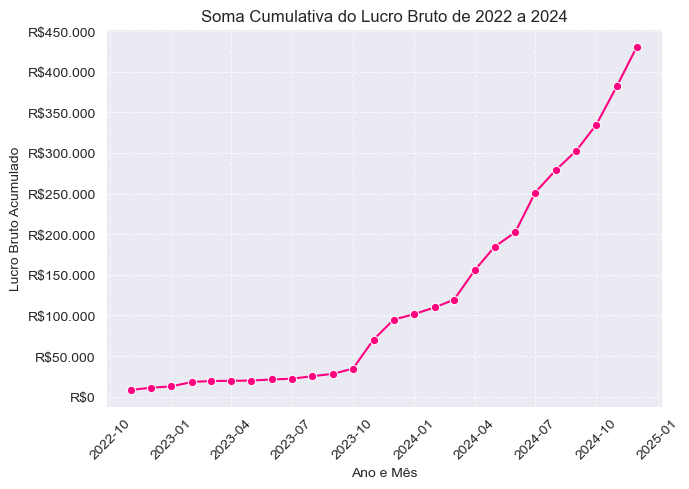

In [512]:
# Adiciona coluna de Ano e Mês
vendas['AnoMes'] = vendas['Data'].dt.to_period('M')

# Agrupamento por Ano e Mês
vendas_mes = vendas.groupby('AnoMes')['Total'].sum().reset_index()
vendas_mes['AnoMes'] = vendas_mes['AnoMes'].dt.to_timestamp()

# Calcula a soma cumulativa
vendas_mes['Total_Cumulativo'] = vendas_mes['Total'].cumsum()

# Plotagem
plt.figure(figsize=(7, 5))
sns.lineplot(data=vendas_mes, x='AnoMes', y='Total_Cumulativo', marker='o')
plt.title('Soma Cumulativa do Lucro Bruto de 2022 a 2024')
plt.ylabel('Lucro Bruto Acumulado')
plt.xlabel('Ano e Mês')
plt.xticks(rotation=45)  # Gira os labels do eixo x para melhor visualização
plt.yticks(ticks=[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000], 
           labels=['R$0', 'R$50.000', 'R$100.000', 'R$150.000', 'R$200.000', 'R$250.000','R$300.000', 'R$350.000', 'R$400.000', 'R$450.000'])
plt.grid(True, linestyle='--', alpha=0.7)  # Adiciona linhas de grade
plt.tight_layout()
plt.show()


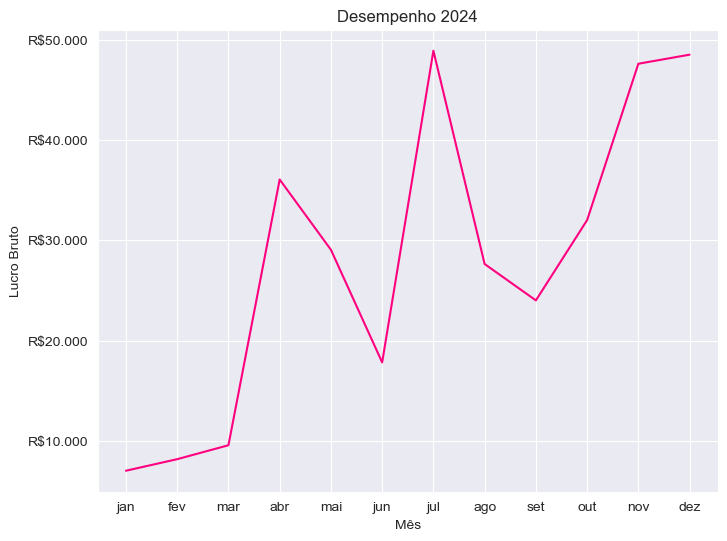

In [468]:
vendas['Mês'] = vendas['Data'].dt.month
vendas_2024 = vendas[vendas['Data'].dt.year == 2024]
vendas_2024 = vendas_2024.groupby('Mês')['Total'].sum().reset_index()

meses = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

plt.figure(figsize=(8,6))
sns.lineplot(data = vendas_2024, x = 'Mês', y = 'Total')
plt.title('Desempenho 2024')
plt.ylabel('Lucro Bruto')
plt.xlabel('Mês')
plt.yticks(ticks = [10000, 20000, 30000, 40000, 50000], labels = ['R$10.000', 'R$20.000', 'R$30.000', 'R$40.000', 'R$50.000'])
plt.xticks(ticks = range(1,13), labels = meses)
plt.show()

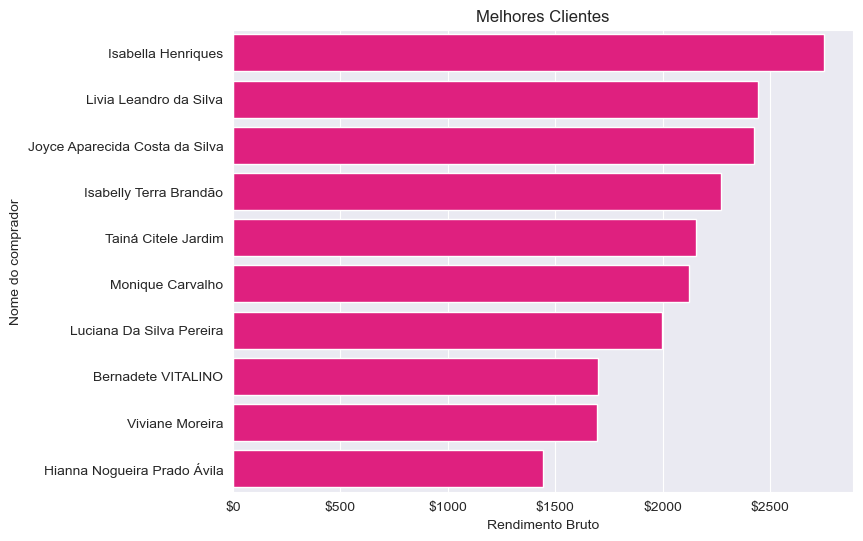

In [469]:
top_clientes = vendas.groupby('Nome do comprador')['Total'].sum().sort_values(ascending = False).reset_index().head(10)

plt.figure(figsize=(8,6))

sns.barplot(data = top_clientes, y = 'Nome do comprador', x = 'Total')
plt.title('Melhores Clientes')
plt.xticks(ticks = [0, 500, 1000, 1500, 2000, 2500], labels = ['$0', '$500', '$1000', '$1500', '$2000', '$2500'])
plt.xlabel('Rendimento Bruto')
plt.show()

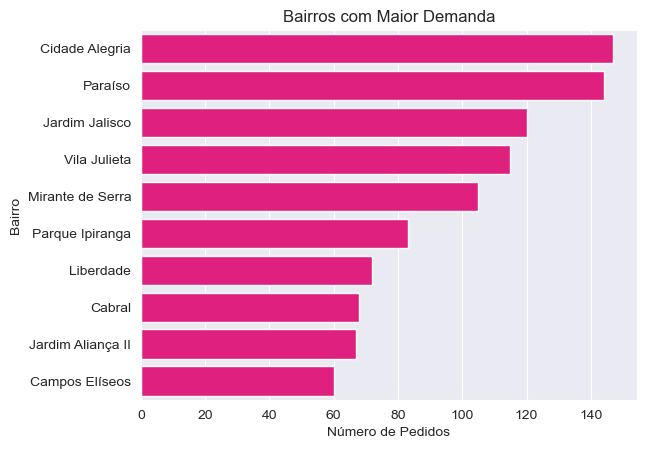

In [470]:
vendas_resende = vendas[vendas['Cidade'] == 'Resende']

top_bairros = vendas_resende['Bairro'].value_counts().sort_values(ascending = False).reset_index().head(10)

sns.barplot(data = top_bairros, x = 'count', y = 'Bairro')
plt.title('Bairros com Maior Demanda')
plt.xlabel('Número de Pedidos')
plt.show()

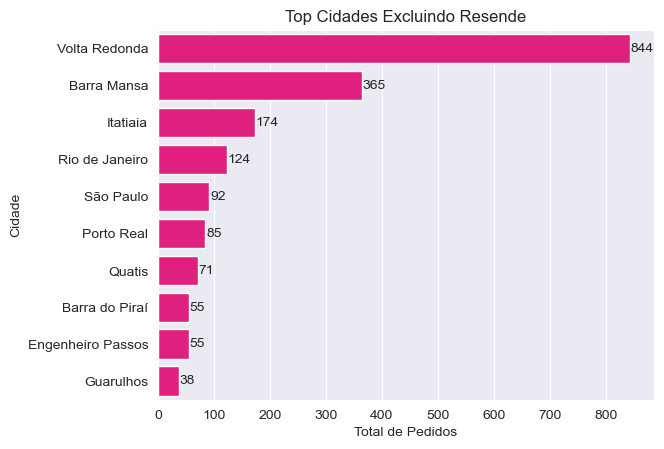

In [471]:
top_cidades = vendas['Cidade'].value_counts().reset_index().head(11)
top_cidades = top_cidades[1:]

ax = sns.barplot(data=top_cidades, x='count', y='Cidade')

# Adiciona os valores no topo das barras
for p in ax.patches:
    ax.annotate(f'{p.get_width():.0f}', 
                (p.get_width() + 1, p.get_y() + p.get_height() / 2),
                ha='left', va='center')
plt.xlabel('Total de Pedidos')
plt.title('Top Cidades Excluindo Resende')
plt.show()

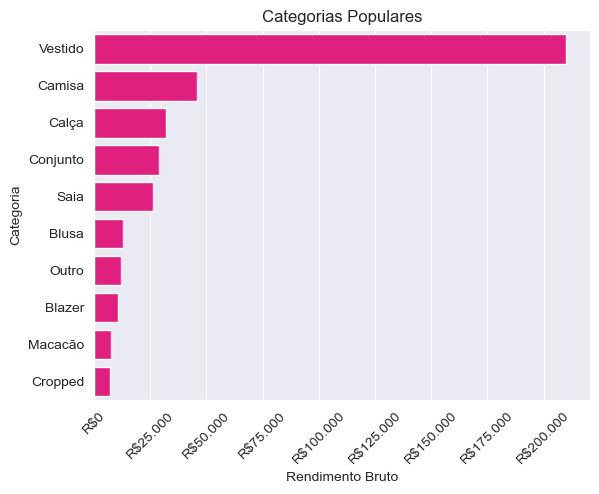

In [528]:
top_categorias = vendas.groupby('Categoria')['Valor do Produto'].sum().sort_values(ascending = False).reset_index().head(10)

sns.barplot(data = top_categorias, x = 'Valor do Produto', y = 'Categoria')
plt.title('Categorias Populares')
plt.xlabel('Rendimento Bruto')
plt.xticks(ticks = [0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000], labels = ['R$0', 'R$25.000', 'R$50.000', 'R$75.000', 'R$100.000', 'R$125.000', 'R$150.000', 'R$175.000', 'R$200.000'], rotation = 45)
plt.show()